# Motion generation with jerk limit

## Introduction

To properly test SIMONA and other hardware devices, it is ideally necessary to use a jerk-limited control signal. In such a signal, position, velocity and acceleration are continuous signals, where the acceleration is typically a piece-wise linear signal, with bounded maximum and minimum jerk values.

We will start off by exploring such signals, and then proceed to define utility functions needed for working with these constraints on implementing motion. 

## Function development

We continue with the development of a function repertoire for motion control with limited jerk values. We can ask ourselves, for example, how much distance is needed for braking a device to standstill, given limitations in jerk, acceleration and velocity. A more general look on this is condidering that acceleration, velocity and position cannot instantly change. Given the limits on acceleration and jerk values, what would be the time and distance needed to transition from a state with velocity and acceleration $v_0$ and $a_0$, to a state with velocity $v_1$ and $a_1$. We therefore need a function:

$$ \Delta x, \Delta t = F(v_0, a_0, v_1, a_1),~ \mathrm{with~constraints} ~j_{max}, a_{max} $$

Using such a function, we could implement a mechanism for monitoring motion of a device, given current velocity and acceleration, and given the motion space calculate the moment when a braking action is needed to end up with zero velocity and acceleration ($v_1 =0$, $a_1 = 0$) at the end of the motion space. 

Let's consider a number of helper quantities, that is, the distance and time needed for;

- a transition from $a_0$ to $a_{max}$, starting with $v_0$:

  $$ \Delta t_0 = \frac{a_{max} - a_0}{j_{max}}, \qquad \Delta x_0 = \frac{\Delta_t^3 j_{max}}{6} + \frac{\Delta_t^2 a_0}{2} + v_0\Delta_t$$
  
- a transition from $a_{max}$ to $a_1$, ending with $v_1$:

  $$ \Delta t_1 = \frac{a_{max} - a_1}{j_{max}}, \qquad \Delta x_1 = \frac{\Delta_t^3 j_{max}}{6} + \frac{\Delta_t^2 a_1}{2} + v_1\Delta_t$$




In [2]:
from sympy import *

jmax = Symbol('j_max') 
a = Symbol('a')
a_0, a_1 = symbols('a_0:2')
t = Symbol('t') 
v = Symbol('v')
v_0, v_1 = symbols('v_0:2')
x = Symbol("x")
Dt = Symbol("\Delta_t")
vi = integrate(a_0+jmax*t, t)
xi = integrate(vi, t)

print("distance traveled in acceleration to ")
integrate(vi, (t, 0, Dt))


distance traveled in acceleration to 


\Delta_t**3*j_max/6 + \Delta_t**2*a_0/2

## Movement design

Typical placement movements would involve an acceleration phase, with increasing speed, until a target speed is reached, a coasting phase with constant speed, and a deceleration phase. 

At the start of the acceleration phase, $a_0 = 0$, and at the end of the acceleration phase, again $a_1 = 0$. An acceleration phase reaching a maximum acceleration $a_{max}$ would therefore at minimum require a time of $2 a_{max}/{j_{max}}$, and cover a distance of

$$ \Delta x = 2 \left( \frac{\Delta_t^3 j_{max}}{6} + \frac{\Delta_t^2 a_{max}}{2} \right) $$

The velocity after the acceleration phase is equal to:

$$ v = \frac{\Delta_t^2 j_{max}}{s} $$

Given the equations elaborated above, and jerking to the maximum acceleration from standstill, then back to minus the maximum acceleration, and returing to neutral this would cover the minimum movement distance given above. Any movement over a distance smaller than that will not reach the maximum acceleration $a_{max}$.

For movements that span a motion $\Delta_x \ge \Delta x_0 + \Delta x_1$, a transition can be defined as a (1) maximum-jerk increase in acceleration, (2) maximum acceleration until close to the maximum speed, (3) negative jerk to stop the acceleration, at the end of that maneuver speed is maximal, (4) an optional coasting phase, (5) negative jerk to maximum negative acceleration, (6) negative acceleration until close to zero speed, (7) positive jerk that ends at zero acceleration and zero speed. 

As a component in calculating these, consider a function that gives the timing for a combined velocity and acceleration change. Given initial velocity and acceleration, and bounds on jerk and maximum acceleration, calculate:

1. Time for the phase of initial acceleration change to either maximum, minimum or an intermediate value, and its associated velocity change.

2. Time for the phase of final acceleration change to final acceleration and its associated velocity change.

3. Time for the intermediate phase at maximum or minimum acceleration, determined by the remaining needed velocity change.

In one case, either the minium or maximum acceleration can be reached, and zero or more time at that acceleration is spent, resulting in three motion phases. 

If that is not possible, i.e., the velocity change is too small to be performed with a phase at maximum or minimum acceleration, the motion starts by an change of initial acceleration to an intermediate acceleration level $a_i$, possibly a period at that intermediate acceleration level, and a change to the final acceleration level $a_1$. 

The time to reach intermediate acceleration $a_i$, is given as:

$$ \Delta t_0 = \frac{\left| a_i - a_0 \right|}{j_{max}} $$
    
Similarly, the time from intermediate acceleration to final acceleration can be calculated:

$$ \Delta t_1 = \frac{\left| a_1 - a_i \right|}{j_{max}} $$
    
Assume an unknown time at constant acceleration, $\Delta t_a$. The total speed change is governed by the following equation:

$$ v_1 - v_0 = \frac{a_0 + a_i}{2}\Delta t_0 + \frac{a_i + a_1}{2}\Delta t_1 + \Delta t_a a_i $$

Substituting the previous results for the times:

$$ v_1 - v_0 = \frac{a_0 + a_i}{2} \frac{\left| a_i - a_0 \right|}{j_{max}} + \frac{a_i + a_1}{2}\frac{\left| a_1 - a_i \right|}{j_{max}} + \Delta t_a a_i $$

Given the two absolute value functions above, this equation needs to be evaluated for different cases, however, knowing the relationship between $a_0$ and $a_i$ may be used to prune these cases:

| $a_1>a_0$ | $a_1<a_0$ | $a_1==a_0$ | absolute 1             | absolute 2             |
|:-----------:|:-----------:|:------------:|:----------------------:|:----------------------:|
|     v     |     v     |     v      | $a_i-a_0 > 0$          | $a_i-a_1 > 0$          |
|     v     |     x     |     x      | $a_i-a_0 > 0$          | $a_i-a_1 < 0$          |
|     x     |     v     |     x      | $a_i-a_0 < 0$          | $a_i-a_1 > 0$          |
|     v     |     v     |     v      | $a_i-a_0 < 0$          | $a_i-a_1 < 0$          |

The second and third case do not provide a solution for $\Delta t_a == 0$, meaning that any $a_i$ achieving the speed difference will be possible.



In [3]:
# helper function to calculate ai for four cases
from IPython.display import display

dv = Symbol('\Delta_v')
ai = Symbol('a_i')
display(solveset(Eq((a_0+ai)*(ai-a_0)+(a_1+ai)*(ai-a_1), 2*jmax*dv), ai))
display(solveset(Eq((a_0+ai)*(a_0-ai)+(a_1+ai)*(ai-a_1), 2*jmax*dv), ai))
display(solveset(Eq((a_0+ai)*(ai-a_0)+(a_1+ai)*(a_1-ai), 2*jmax*dv), ai))
display(solveset(Eq((a_0+ai)*(a_0-ai)+(a_1+ai)*(a_1-ai), 2*jmax*dv), ai))
#solveset(Eq((a_0+ai)*Abs(ai-a_0)+(a_1+ai)*Abs(ai-a_1), 2*jmax*dv), ai)

         
def solve_ai(v0: float, a0: float, v1: float, a1: float, j_max: float):
    
    det = [2*(v1-v0)*j_max + a1**2 + a0**2, -2*(v1-v0)*j_max + a1**2 + a0**2]
    return [ 0.5*np.sqrt(2*d) for d in det if d >= 0]
        
# apparently, and quite logically, the two middle cases have no solution because ai^2 
# is removed from the equation. These will only give a result when considering a
# constant ai acceleration contribution. In these cases
# a0 > ai > a1 and a1 > ai > a0; when not considering a constant level, these would
# simply assume the linear transition from a0 to a1
    
    

{-sqrt(2)*sqrt(2*\Delta_v*j_max + a_0**2 + a_1**2)/2, sqrt(2)*sqrt(2*\Delta_v*j_max + a_0**2 + a_1**2)/2}

EmptySet

EmptySet

{-sqrt(2)*sqrt(-2*\Delta_v*j_max + a_0**2 + a_1**2)/2, sqrt(2)*sqrt(-2*\Delta_v*j_max + a_0**2 + a_1**2)/2}

Re-thinking this, there are a number of cases to consider. Given acceleration $a_0$ and $a_1$, we can have:

- No intermediate acceleration; this would be a case where the $\Delta v$ step exactly matches the transition from $a_0$ to $a_1$, with jerk value $j_{max}$.

- An intermediate acceleration level $a_i$, with $a_0 \le a_i \le a_1$, if $a_1 > a_0$, or vice versa. However, this would be a slower transition than the fastest possible, and the next case would be a better option. 

- A temporary transition to an acceleration level $a_i$ outside the $a_0 \ldots a_1$ range, given by one of the above solutions.

- If that temporary acceleration level is outside the maximum boundaries, a section of constant acceleration at $a_i = a_{max}$ or $a_i = -a_{max}$

## Motion test signals requirements

The purpose of the test signals is a quick evaluation of the motion capabilities. Agard 144 describes an extensive series, here we want a few short motions, for some specific purposes:

- Detection of reversal bump
- Parasitic motion introduced by the drive (incorrect mechanics, etc.)
- Frequency response and noise level

### Detection of reversal bump

For the detection of reversal bump, it is imperative that a clean and slow reversal of motion direction is made. Absolute perception thresholds in lateral and forward direction are given as 0.085 $m/s^5$ and 0.065 $m/s^2$, see,

> Kingma, H. “Thresholds for Perception of Direction of Linear Acceleration as a Possible Evaluation of the Otolith Function.” BMC Ear, Nose and Throat Disorders 5, no. 1 (December 2005): 5. https://doi.org/10.1186/1472-6815-5-5.

A heave motion will load all actuators in a similar manner, a sway or surge will have part of the actuators extending, part contracting. Speed levels of 0.1 and 0.05 $m/s$, and acceleration transitions in the threshold region 0.1, 0.05, 0.02 $m/s^2$. 

### Parasitic drive motion

Inaccuracies in actuators and control might introduce parasitic motion to the intended motion. For this, linear, constant velocity motion is considered. There are two options; a motion that is linear in the motion space, but then non-linear in the actuator space will be easiest to implement, a motion that is linear in actuator space would give the purest test of a single actuator. The explored functions give acceleration, velocity and position for a jerk-limited, acceleration-limited motion at constant speed and over a given range. For three linear degrees of freedom this requires 100 s

### Frequency and noise level

This is a more holistic test, which uses a sinusoidal function in motion space to test the drive. To condense the needed time, a sum-of-sines function will be used, with base frequencies spaced to enable detection of harmonics, i.e. higher frequency base and harmonic frequencies avoid those of lower-frequencies. A start of this signal can be done with a cosine fade in. This can be done for all basic degrees of freedom, and requires approximately 2 minutes per degree of freedom, i.e., 12 minutes.

The following cell shows the derivation of velocity and acceleration for a fade-in of a sinusoid.


In [4]:
from sympy import *
Tfade = Symbol('T_{fade}')
Pfade = Symbol('\phi_{fade}')
phi0 = Symbol('\phi_0')
omg = Symbol('\omega')
t = Symbol('t')

# basic sine signal with frequency omg, fade-in pertiod over a time Tfade, 
# the initial phase for the fading cosine, Pfade, is manipulated to create
# either a fade-in (Pfade = 0, t0 = 0) or a fade-out (Pfade manipulated
# so that pi*t/Tfade+Pfade = pi at the start of fade-out.
y = sin(omg*t+phi0)*(1-cos(pi*t/Tfade+Pfade))/2

# pretty-show the function, its derivative (speed), and second derivative
display(y)
display(diff(y, t))
display(diff(diff(y, t), t))

(1 - cos(\phi_{fade} + pi*t/T_{fade}))*sin(\omega*t + \phi_0)/2

\omega*(1 - cos(\phi_{fade} + pi*t/T_{fade}))*cos(\omega*t + \phi_0)/2 + pi*sin(\phi_{fade} + pi*t/T_{fade})*sin(\omega*t + \phi_0)/(2*T_{fade})

-\omega**2*(1 - cos(\phi_{fade} + pi*t/T_{fade}))*sin(\omega*t + \phi_0)/2 + pi*\omega*sin(\phi_{fade} + pi*t/T_{fade})*cos(\omega*t + \phi_0)/T_{fade} + pi**2*sin(\omega*t + \phi_0)*cos(\phi_{fade} + pi*t/T_{fade})/(2*T_{fade}**2)

# Implementation details

## Update/motivation

The original movement signals were mostly "hand-crafted", resulting in directly calculated `numpy` arrays with position, velocity and acceleration data. In a re-design of the underlying software, generation of the different movement types have been combined to generate a `MotionProfile`, an algorithmic description of the movement, which can then generate -- by interpolation -- a resulting control matrix. 

## Pose

The `algopose.py` file contains a definition of the `Pose` class, which defines a rigid-body position, orientation and its associated velocities, in a 13-element vector, with a quaternion defining orientation. 

## Movement

A `Movement` defines a transition from one Pose to another Pose, with both poses having zero velocity. The movement is limited in speed, acceleration and jerk. There is a factor, translating the linear limits to rotational speed, acceleration and jerk limits. The movement occurs along the shortest path between the two poses, i.e., as a linear path from one pose to the other, combined with a rotation around a constant (in space) axis. The movement consists of a constant jerk phase, constant acceleration phase (optional), constant speed coasting (also optional), and then constant deceleration, and constant jerk.

An optional time step ensures that the phases are rounded to the nearest higher time increment; jerk and acceleration may be reduced from maximum jerk and maximum acceleration. 



## ProfileMotion

A `ProfileMotion` defines a movement starting at a specific pose, along a 6 element movement axis (three linear elements, and 3 elements defining a rotation axis), with a specific profile created by another object. The currently available profiles are a faded sine sum profile (`FadedSineProfile`); a constant, jerk-limited acceleration profile (`ConstantAccelProfile`) and a constant speed profile (`ConstantSpeedProfile`). 


# Sine test motions

The cells below generate motion files for sine test signals. Three sets are generated, with low-frequency, mid-frequency and high-frequency sines. A moment of neutral positioning (`Still`) is added before and after the motion, and the `FadedSineProfile` is run, once for each linear and once for each rotary degree of freedom. 

Common harmonics between base waves 3 and 5: {15}
gains: [0.15       0.13037973 0.08148733 0.04656419]
Move of type Still duration 1.0 starting 0.0
Move of type ProfileMotion duration 53.0 starting 1.0
Move of type ProfileMotion duration 53.0 starting 54.0
Move of type ProfileMotion duration 53.0 starting 107.0
Move of type ProfileMotion duration 53.0 starting 160.0
Move of type ProfileMotion duration 53.0 starting 213.0
Move of type ProfileMotion duration 53.0 starting 266.0
Move of type Still duration 1.0 starting 319.0


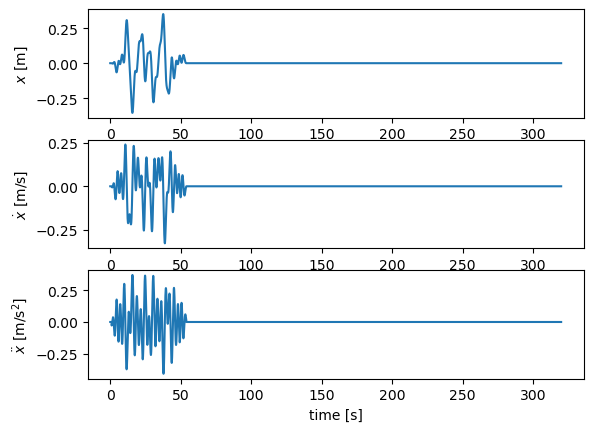

In [9]:
# When developing, make sure that updated versions of the sineAnalysis are
# used.
from matplotlib import pyplot as plt
import numpy as np
import importlib
import sys
sys.path.append('../motiontools')
try:
    importlib.reload(sys.modules['algopose'])
    importlib.reload(sys.modules['motiongen'])
    print("reloaded motiongen.py algopose.py")
except:
    pass

from algopose import MovementSeries, Pose, Still, ProfileMotion, Movement, FadedSineProfile
from motiongen import checkHarmonics, sineAmplitude

# sine signals, with a base frequency of 40.96, total time 60 second, fade-in-out 9 
Tbase = 40.96                   # base measurement/analysis time
dt = 0.01                       # time step for calculating the test signal
Tfade = 6.0                     # fade-in, fade-out
Ttotal = 53.0                   # total signal time, 2xTfade + Tbase + margin
xmax = 0.15                     # maximum linear position, per sine
vmax = 0.1                      # maximum linear velocity, per sine
amax = 0.3                      # maximum linear accel, per sine
rfactor = 0.5                   # factor between linear [m] and rotational [rad]

# low-frequency sines
waves_lo = [3, 5, 8, 14]
omg = np.array(waves_lo)*2*np.pi/Tbase
phi0 = np.array((0.4, 4.0, 1.3, 4.5))
checkHarmonics(waves_lo, 5)
# Calculate sine gaines to comply to the limits
gains = sineAmplitude(omg, xmax, vmax, amax)
print("gains:", gains)

# start pose
xyz0 = ptp0 = np.zeros((3,))
start = Pose(xyz0, ptp0)

# Use ProfileMotion with a sum-of-sines profile to test all axes
moves = []
moves.append(Still(start, 1.0))
fader = FadedSineProfile(Tfade, Ttotal, omg, gains, phi0)
moves.append(ProfileMotion(start, [1, 0, 0, 0, 0, 0], fader))
moves.append(ProfileMotion(start, [0, 1, 0, 0, 0, 0], fader))
moves.append(ProfileMotion(start, [0, 0, 1, 0, 0, 0], fader))
moves.append(ProfileMotion(start, [0, 0, 0, rfactor, 0, 0], fader))
moves.append(ProfileMotion(start, [0, 0, 0, 0, rfactor, 0], fader))
moves.append(ProfileMotion(start, [0, 0, 0, 0, 0, rfactor], fader))
moves.append(Still(start, 1.0))

# calculate the motions
fn = MovementSeries(moves)
dt = 0.01
time = np.arange(0, fn.duration(), dt)
sign = np.zeros((time.shape[0], 18))

# convert to an inputs matrix
for i, t in enumerate(time):
    pose = fn.position(t)
    sign[i,:3] = pose.xyz()
    sign[i,3:6] = pose.euler()
    sign[i,6:12] = fn.velocity(t)
    sign[i,12:] = fn.accel(t)

# example/check plots, for one dof
plt.figure()
plt.subplot(3,1,1)
plt.plot(time, sign[:,0])
plt.xlabel('time [s]')
plt.ylabel('$x~\mathrm{[m]}$')
plt.subplot(3,1,2)
plt.plot(time, sign[:,6])
plt.xlabel('time [s]')
plt.ylabel('$\dot{x}~\mathrm{[m/s]}$')
plt.subplot(3,1,3)
plt.plot(time, sign[:,12])
plt.xlabel('time [s]')
plt.ylabel('$\ddot{x}~\mathrm{[m/s^2]}$')
          
txt = [f"""## Sum of sines input

The first collection of sines covers the lower frequency. The following 
limitations per sine component are used:

| quantity          | maximum | unit |
| ----------------- | ------- | ----  |
| linear excursion  | {xmax}  | [m] |
| linear speed      | {vmax}  | [m/s] |
| linear excursion  | {amax}  | [m/s2] |
| rotational excursion  | {xmax*rfactor}  | [rad] |
| rotational speed      | {vmax*rfactor}  | [rad/s] |
| rotational excursion  | {amax*rfactor}  | [rad/s2] |

## Component amplitudes, linear

| frequency <br> [rad/s] | x <br> [m] | v <br> [m/s | a <br> [m/s2] |
| ---------------------- | ---------- | ----------- | ------------ |"""]

for w,g in zip(omg.reshape((-1,)), gains.reshape((-1,))):
    txt.append(f"""
| {w:.3f} | {g:.5f} | {g*w:.5f} | {g*w**2:.5f} |""")




In [10]:
import json

# save the sine signals
with open("srs-test-motion-sines1.dat", 'w') as f:
    np.savetxt(f, sign)

# save a JSON file with the movement sequence
with open("srs-test-motion-sines1.json", 'w') as fj:
    json.dump(fn.json(), fj)


In [11]:
from IPython.display import clear_output, display, Markdown

# Higher frequency sines
waves_hi = [23, 43, 67, 101, 171]
checkHarmonics(waves_hi, 5)
omg = np.array((waves_hi)) *2*np.pi/40.96
phi0 = np.array((0.4, 4.0, 1.3, 4.5, 3.0))

gains = sineAmplitude(omg, xmax, vmax, amax)
faderh = FadedSineProfile(Tfade, Ttotal, omg, gains, phi0)
im = len(moves) - 1
moves.append(ProfileMotion(start, [1, 0, 0, 0, 0, 0], faderh))
moves.append(ProfileMotion(start, [0, 1, 0, 0, 0, 0], faderh))
moves.append(ProfileMotion(start, [0, 0, 1, 0, 0, 0], faderh))
moves.append(ProfileMotion(start, [0, 0, 0, rfactor, 0, 0], faderh))
moves.append(ProfileMotion(start, [0, 0, 0, 0, rfactor, 0], faderh))
moves.append(ProfileMotion(start, [0, 0, 0, 0, 0, rfactor], faderh))
moves.append(Still(start, 1))

for w,g in zip(omg.reshape((-1,)), gains.reshape((-1,))):
    txt.append(f"""
| {w:.3f} | {g:.5f} | {g*w:.5f} | {g*w**2:.5f} |""")

# Markdown(''.join(txt))

In [12]:
# Part 1b, drive signals for the simulator; running x, y, z, phi, theta, psi inputs

fn = MovementSeries(moves[im:])
time = np.arange(0, fn.duration(), dt)
sign = np.zeros((time.shape[0], 18))

for i, t in enumerate(time):
    pose = fn.position(t)
    sign[i,:3] = pose.xyz()
    sign[i,3:6] = pose.euler()
    sign[i,6:12] = fn.velocity(t)
    sign[i,12:] = fn.accel(t)

# save the sine signals
with open("srs-test-motion-sines2.dat", 'w') as f:
    np.savetxt(f, sign)

# save a JSON file with the movement sequence
with open("srs-test-motion-sines2.json", 'w') as fj:
    json.dump(fn.json(), fj)


Move of type Still duration 1.0 starting 0.0
Move of type ProfileMotion duration 53.0 starting 1.0
Move of type ProfileMotion duration 53.0 starting 54.0
Move of type ProfileMotion duration 53.0 starting 107.0
Move of type ProfileMotion duration 53.0 starting 160.0
Move of type ProfileMotion duration 53.0 starting 213.0
Move of type ProfileMotion duration 53.0 starting 266.0
Move of type Still duration 1 starting 319.0


In [13]:
from IPython.display import clear_output, display, Markdown
import json

# Higher frequency sines
waves_hihi = [227, 331, 443, 589, ]
checkHarmonics(waves_hi, 5)
omg = np.array((waves_hihi)) *2*np.pi/40.96
phi0 = np.array((0.4, 4.0, 1.3, 4.5))

gains = sineAmplitude(omg, xmax, vmax, amax)

faderu = FadedSineProfile(Tfade, Ttotal, omg, gains, phi0)
im = len(moves) - 1
moves.append(ProfileMotion(start, [1, 0, 0, 0, 0, 0], faderu))
moves.append(ProfileMotion(start, [0, 1, 0, 0, 0, 0], faderu))
moves.append(ProfileMotion(start, [0, 0, 1, 0, 0, 0], faderu))
moves.append(ProfileMotion(start, [0, 0, 0, rfactor, 0, 0], faderu))
moves.append(ProfileMotion(start, [0, 0, 0, 0, rfactor, 0], faderu))
moves.append(ProfileMotion(start, [0, 0, 0, 0, 0, rfactor], faderu))
moves.append(Still(start, 1))
#print(gains)

#gains = np.array((0.03, 0.01, 0.007, 0.005, 0.003)).reshape((-1,1))


for w,g in zip(omg.reshape((-1,)), gains.reshape((-1,))):
    txt.append(f"""
| {w:.3f} | {g:.5f} | {g*w:.5f} | {g*w**2:.5f} |""")

Markdown(''.join(txt))

## Sum of sines input

The first collection of sines covers the lower frequency. The following 
limitations per sine component are used:

| quantity          | maximum | unit |
| ----------------- | ------- | ----  |
| linear excursion  | 0.15  | [m] |
| linear speed      | 0.1  | [m/s] |
| linear excursion  | 0.3  | [m/s2] |
| rotational excursion  | 0.075  | [rad] |
| rotational speed      | 0.05  | [rad/s] |
| rotational excursion  | 0.15  | [rad/s2] |

## Component amplitudes, linear

| frequency <br> [rad/s] | x <br> [m] | v <br> [m/s | a <br> [m/s2] |
| ---------------------- | ---------- | ----------- | ------------ |
| 0.460 | 0.15000 | 0.06903 | 0.03177 |
| 0.767 | 0.13038 | 0.10000 | 0.07670 |
| 1.227 | 0.08149 | 0.10000 | 0.12272 |
| 2.148 | 0.04656 | 0.10000 | 0.21476 |
| 3.528 | 0.02410 | 0.08503 | 0.30000 |
| 6.596 | 0.00690 | 0.04548 | 0.30000 |
| 10.278 | 0.00284 | 0.02919 | 0.30000 |
| 15.493 | 0.00125 | 0.01936 | 0.30000 |
| 26.231 | 0.00044 | 0.01144 | 0.30000 |
| 34.821 | 0.00025 | 0.00862 | 0.30000 |
| 50.775 | 0.00012 | 0.00591 | 0.30000 |
| 67.955 | 0.00006 | 0.00441 | 0.30000 |
| 90.351 | 0.00004 | 0.00332 | 0.30000 |

In [14]:
# Part 1b, drive signals for the simulator; running x, y, z, phi, theta, psi inputs

fn = MovementSeries(moves[im:])
time = np.arange(0, fn.duration(), dt)
sign = np.zeros((time.shape[0], 18))

for i, t in enumerate(time):
    pose = fn.position(t)
    sign[i,:3] = pose.xyz()
    sign[i,3:6] = pose.euler()
    sign[i,6:12] = fn.velocity(t)
    sign[i,12:] = fn.accel(t)

with open("srs-test-motion-sines3.dat", 'w') as f:
    np.savetxt(f, sign)

# save a JSON file with the movement sequence
with open("srs-test-motion-sines3.json", 'w') as fj:
    json.dump(fn.json(), fj)
print("data and json files written")

Move of type Still duration 1 starting 0.0
Move of type ProfileMotion duration 53.0 starting 1.0
Move of type ProfileMotion duration 53.0 starting 54.0
Move of type ProfileMotion duration 53.0 starting 107.0
Move of type ProfileMotion duration 53.0 starting 160.0
Move of type ProfileMotion duration 53.0 starting 213.0
Move of type ProfileMotion duration 53.0 starting 266.0
Move of type Still duration 1 starting 319.0
data and json files written


## Parasitic drive motion test

This test is meant do detect if there are parasitic motions generated, e.g., by roughness of cylinders, gearing, or the like. It uses a range of velocities, from moderate to high, and linear motion (in device space), in the linear axes.

For the SIMONA Research Simulator, linear movements at representative velocities 0.1 $m/s$, 0.4 $m/s$ and 0.7 $m/s$, heave, surge and sway. 

reloaded motiongen.py
linear 0.5 angle 0.0
linear 1.0 angle 0.0
linear 1.0 angle 0.0
linear 1.0 angle 0.0
linear 1.0 angle 0.0
linear 1.0 angle 0.0
need to adjust accel phase for coasting speed
linear 1.0 angle 0.0
need to adjust accel phase for coasting speed
linear 0.6726812023536856 angle 0.0
need to adjust accel phase for coasting speed
linear 0.9 angle 0.0
linear 0.9 angle 0.0
linear 0.9 angle 0.0
linear 0.9 angle 0.0
linear 0.9 angle 0.0
need to adjust accel phase for coasting speed
linear 0.9 angle 0.0
need to adjust accel phase for coasting speed
linear 0.6363961030678927 angle 0.0
need to adjust accel phase for coasting speed
linear 0.9 angle 0.0
linear 0.9 angle 0.0
linear 0.9 angle 0.0
linear 0.9 angle 0.0
linear 0.9 angle 0.0
need to adjust accel phase for coasting speed
linear 0.9 angle 0.0
need to adjust accel phase for coasting speed
linear 0.45 angle 0.0
need to adjust accel phase for coasting speed
Move of type Still duration 1 starting 0.0
Move of type Movement durati

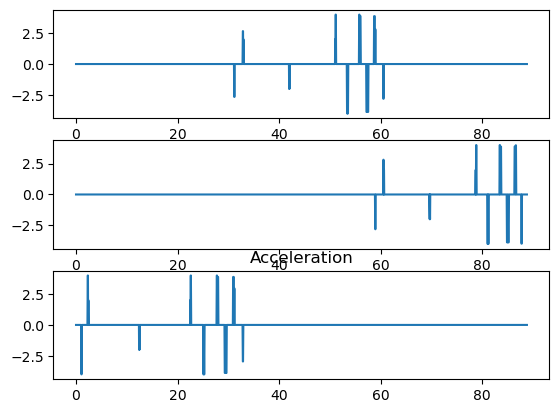

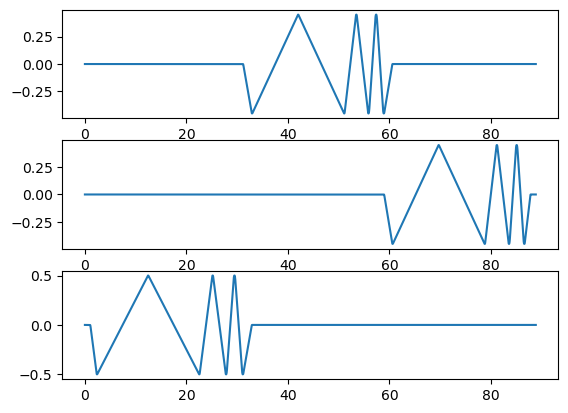

In [15]:
try:
    importlib.reload(sys.modules['motiongen'])
    importlib.reload(sys.modules['algopose'])
    importlib.reload(sys.modules['jlimits'])
    print("reloaded motiongen.py")
except:
    pass

from algopose import Pose, Movement
import json

z_max = 0.5
y_max = 0.8
x_max = 0.8

vmx0 = 0.4  # [m/s]
amx = 4  # [m/s2], linear accel
jmx = 1/dt # [m/s3], linear accel

z_min = Pose([0, 0, -0.5], ptp0)
z_max = Pose([0, 0,  0.5], ptp0)
im = len(moves) - 1

# move to down position
moves.append(Movement(start, z_min, vmx0, amx, jmx, rfactor, dt))
speeds = (0.1, 0.4, 0.7)
accels = (amx/2, amx, amx)

# there and back moves, different speeds
for amx, vmx in zip(accels, speeds):
    moves.append(Movement(z_min, z_max, vmx, amx, jmx, rfactor, dt))
    moves.append(Movement(z_max, z_min, vmx, amx, jmx, rfactor, dt))

# forward and back
x_min = Pose([-0.45, 0, 0], ptp0)
x_max = Pose([ 0.45, 0, 0], ptp0)

# initial move
moves.append(Movement(z_min, x_min, vmx0, amx, jmx, rfactor, dt))

for amx, vmx in zip(accels, speeds):
    moves.append(Movement(x_min, x_max, vmx, amx, jmx, rfactor, dt))
    moves.append(Movement(x_max, x_min, vmx, amx, jmx, rfactor, dt))

# left and right
y_min = Pose([0, -0.45, 0], ptp0)
y_max = Pose([0,  0.45, 0], ptp0)

# initial move
moves.append(Movement(x_min, y_min, vmx0, amx, jmx, rfactor, dt))

for amx, vmx in zip(accels, speeds):
    moves.append(Movement(y_min, y_max, vmx, amx, jmx, rfactor, dt))
    moves.append(Movement(y_max, y_min, vmx, amx, jmx, rfactor, dt))

# back to neutral
moves.append(Movement(y_min, start, vmx0, amx, jmx, rfactor, dt)) 
moves.append(Still(start, 1.0))

fn = MovementSeries(moves[im:])
time = np.arange(0, fn.duration(), dt)
sign = np.zeros((time.shape[0], 18))

for i, t in enumerate(time):
    pose = fn.position(t)
    sign[i,:3] = pose.xyz()
    sign[i,3:6] = pose.euler()
    sign[i,6:12] = fn.velocity(t)
    sign[i,12:] = fn.accel(t)

with open("srs-test-motion-pmd.dat", 'w') as f:
    np.savetxt(f, sign)

plt.figure()
plt.subplot(3,1,1)
plt.plot(time, sign[:,12])
plt.subplot(3,1,2)
plt.plot(time, sign[:,13])
plt.subplot(3,1,3)
plt.plot(time, sign[:,14])
plt.title("Acceleration")

plt.figure()
plt.subplot(3,1,1)
plt.plot(time, sign[:,0])
plt.subplot(3,1,2)
plt.plot(time, sign[:,1])
plt.subplot(3,1,3)
plt.plot(time, sign[:,2])

print(f"position max x: {np.max(sign[:,0])} y: {np.max(sign[:,1])} z: {np.max(sign[:,2])}")
print(f"position min x: {np.min(sign[:,0])} y: {np.min(sign[:,1])} z: {np.min(sign[:,2])}")

# write the characteristics of the motion in a json file, for
# use in the analysis later
with open('srs-test-motion-pmd.json', 'w') as mf:
    json.dump(fn.json(), mf)


## Reversal bump test

Traditional reversal bump inspection is from slow sinusoidal movements. This requires a large movement stroke during which no occurrence of reversal bumps is present, hence no data of interest is generated. Here instead, reversal is detected from low velocity, low acceleration movements. $v = 0.05~\mathrm{m/s}$, different acceleration levels. The movements are strung together by constant acceleration profiles, with some constant speed sections to keep the motion from drifting away too much. After the motion sequence, the simulator is re-positioned to neutral with a Movement.

reloaded algopose.py motiongen.py
linear 0.01597500000000501 angle 0.0
need to adjust accel phase for coasting speed
Move of type ProfileMotion duration 1.01 starting 0.0
Move of type ProfileMotion duration 2.01 starting 1.01
Move of type ProfileMotion duration 1.0 starting 3.0199999999999996
Move of type ProfileMotion duration 2.01 starting 4.02
Move of type ProfileMotion duration 3.01 starting 6.029999999999999
Move of type ProfileMotion duration 1.0 starting 9.04
Move of type ProfileMotion duration 2.01 starting 10.04
Move of type ProfileMotion duration 3.51 starting 12.049999999999999
Move of type ProfileMotion duration 1.0 starting 15.559999999999999
Move of type ProfileMotion duration 2.01 starting 16.56
Move of type ProfileMotion duration 3.01 starting 18.57
Move of type ProfileMotion duration 1.0 starting 21.58
Move of type ProfileMotion duration 2.01 starting 22.58
Move of type ProfileMotion duration 3.01 starting 24.589999999999996
Move of type ProfileMotion duration 1.0 star

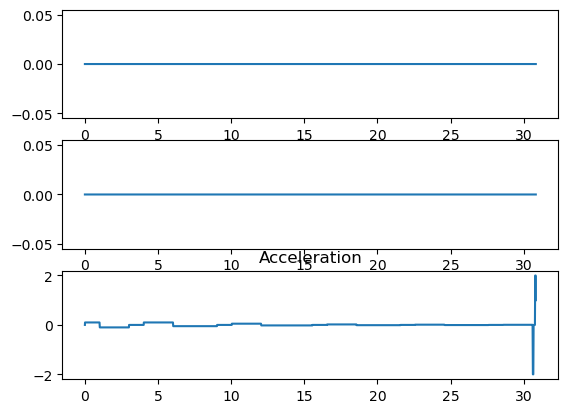

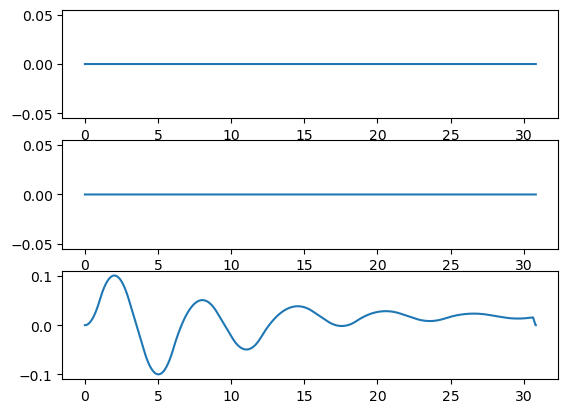

In [16]:
try:
    importlib.reload(sys.modules['algopose'])
    print("reloaded algopose.py motiongen.py")
except:
    pass

from algopose import Movement, MovementSeries, Pose, Still, \
    ConstantAccelProfile, ConstantSpeedProfile, ProfileMotion

import json

im = len(moves)

# acceleration levels
accs = (0.1, 0.05, 0.02, 0.01, 0.005)
vels = (0.1, 0.05, 0.02, 0.01, 0.005)

# start position
xyz0 = ptp0 = np.zeros((3,))
start = Pose(xyz0, ptp0)

# acceleration to initial speed and acceleration
accmove0 = ConstantAccelProfile(0.0, 0.0, 0.0, vels[0], accs[0], jmx, 0.01)
moves.append(ProfileMotion(start, [0, 0, 1, 0, 0, 0], accmove0))
xnow = moves[-1].position(moves[-1].duration())

lastv = vels[0]

# different acceleration and speed levels
for a, v in zip(accs, vels):
    # arc up, negative acceleration and from positive (down) speed to negative (up) speed 
    accm = ConstantAccelProfile(0.0, lastv, 0.0, -v, a, jmx, 0.01)
    moves.append(ProfileMotion(xnow, [0, 0, 1, 0, 0, 0], accm))
    xnow = moves[-1].position(moves[-1].duration())

    # float at constant speed
    cvel = ConstantSpeedProfile(-v, 1.0)
    moves.append(ProfileMotion(xnow, [0, 0, 1, 0, 0, 0], cvel))
    xnow = moves[-1].position(moves[-1].duration())
    
    # back up
    accp = ConstantAccelProfile(0.0, -v, 0.0, v, a, jmx, 0.01)
    moves.append(ProfileMotion(xnow, [0, 0, 1, 0, 0, 0], accp))
    xnow = moves[-1].position(moves[-1].duration())
    lastv = v

# back to zero speed
acc0 = ConstantAccelProfile(0.0, lastv, 0.0, 0.0, a, jmx, 0.01)
xnow = moves[-1].position(moves[-1].duration())

# set back to start
moves.append(Movement(xnow, start, 0.1, 2, 100, 0.5, 0.01))

fn = MovementSeries(moves[im:])
time = np.arange(0, fn.duration(), dt)
sign = np.zeros((time.shape[0], 18))

for i, t in enumerate(time):
    pose = fn.position(t)
    sign[i,:3] = pose.xyz()
    sign[i,3:6] = pose.euler()
    sign[i,6:12] = fn.velocity(t)
    sign[i,12:] = fn.accel(t)

with open("srs-test-motion-bump.dat", 'w') as f:
    np.savetxt(f, sign)

plt.figure()
plt.subplot(3,1,1)
plt.plot(time, sign[:,12])
plt.subplot(3,1,2)
plt.plot(time, sign[:,13])
plt.subplot(3,1,3)
plt.plot(time, sign[:,14])
plt.title("Acceleration")

plt.figure()
plt.subplot(3,1,1)
plt.plot(time, sign[:,0])
plt.subplot(3,1,2)
plt.plot(time, sign[:,1])
plt.subplot(3,1,3)
plt.plot(time, sign[:,2])

# as a by-product, save the moves file
with open('srs-test-motion-bump.json', 'w') as mf:
    json.dump(fn.json(), mf)




## Motion file preparation

On the SIMONA research simulator, motion can be played with the `ReplayMotionFilter` in the `JBMotionTest` project. Standard motion files are at 100 Hz, no additional lead-in. Data are ASCII, with space-separated numbers. From the `ReplayMotionFilter` file:

    while(!file_stream.eof()) {
        // data
        file_stream >> pva_in.x;
        file_stream >> pva_in.y;
        file_stream >> pva_in.z;
        file_stream >> pva_in.phi;
        file_stream >> pva_in.theta;
        file_stream >> pva_in.psi;
        file_stream >> pva_in.xdot;
        file_stream >> pva_in.ydot;
        file_stream >> pva_in.zdot;
        file_stream >> pva_in.p;
        file_stream >> pva_in.q;
        file_stream >> pva_in.r;
        file_stream >> pva_in.xdotdot;
        file_stream >> pva_in.ydotdot;
        file_stream >> pva_in.zdotdot;
        file_stream >> pva_in.pdot;
        file_stream >> pva_in.qdot;
        file_stream >> pva_in.rdot; 
    
        pva_queue.push_back(pva_in);
    }

To ensure a good start, add 2 s of zeros at the beginning of the file, then insert the motions calculated above.

The cells above have generated the following files:

| file | motion profile |
| ---- | -------------- |
| `srs-test-motion-sines1.dat` | Set of sum-of-sines inputs, low frequency, per degree of freedom, for determining gain, phase, harmonics, noise and crossfeed |
| `srs-test-motion-sines2.dat` | Set of mid-frequency sum-of-sines inputs |
| `srs-test-motion-sines3.dat` | Set of high-frequency sum-of-sines inputs |
| `srs-test-motion-pmd.dat` | Motion with constant-speed input, in the linear degrees of freedom, to test motion capability at different speeds and noise/rumble |
| `srs-test-motion-bump.dat`   | Slow, constant-acceleration stretches during which the motion direction reverses; to detect motion reversal bump |

A set of auxiliary files with information on the generated inputs is produced. These are later read by the `motion-analysis` notebook for the analysis steps.

| file | function |
| ---- | -------------- |
| `srs-test-motion-sines1.json` | Information on the low frequency sine signal |
| `srs-test-motion-sines2.json` | Information on the mid frequency sine signal |
| `srs-test-motion-sines3.json` | Information on the high frequency sine signal |
| `srs-test-motion-pdm.json`  | Information on the constant-velocity movement signals |
| `srs-test-motion-bump.json` | Information on the reversal bump signals |


# Reversal bump location

Does the initial position for a reversal bump test make a difference? Running this at different locations.

- Top
- Bottom
- Front



reloaded algopose.py motiongen.py
linear 0.5 angle 0.0
linear 0.9814999999999949 angle 0.0
need to adjust accel phase for coasting speed
linear 0.7929957439986707 angle 0.0
need to adjust accel phase for coasting speed
linear 0.018500000000005064 angle 0.0
need to adjust accel phase for coasting speed
linear 0.600285140579042 angle 0.0
need to adjust accel phase for coasting speed
Move of type Movement duration 2.62 starting 0.0
Move of type ProfileMotion duration 1.01 starting 2.62
Move of type ProfileMotion duration 2.01 starting 3.63
Move of type ProfileMotion duration 1.0 starting 5.64
Move of type ProfileMotion duration 2.01 starting 6.64
Move of type ProfileMotion duration 3.01 starting 8.649999999999999
Move of type ProfileMotion duration 1.0 starting 11.659999999999998
Move of type ProfileMotion duration 2.01 starting 12.659999999999998
Move of type ProfileMotion duration 3.51 starting 14.669999999999998
Move of type ProfileMotion duration 1.0 starting 18.18
Move of type Profil

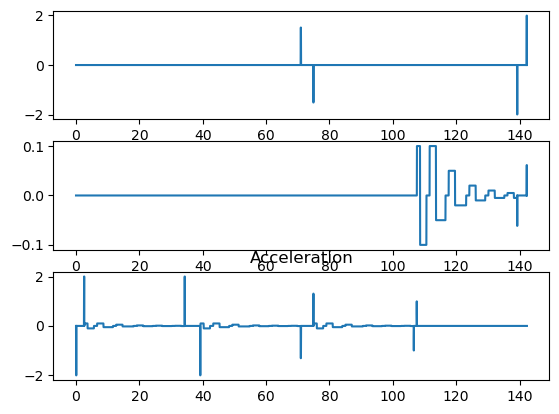

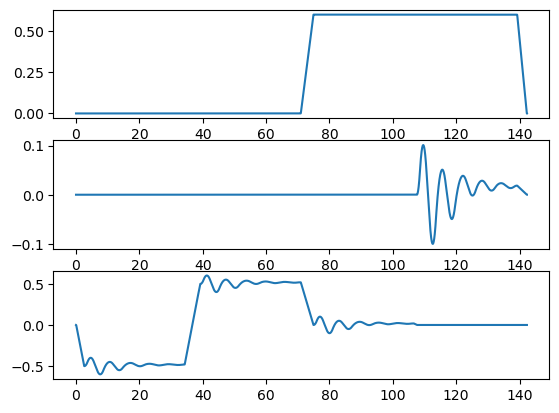

In [20]:
try:
    importlib.reload(sys.modules['algopose'])
    print("reloaded algopose.py motiongen.py")
except:
    pass

from algopose import Movement, MovementSeries, Pose, Still, \
    ConstantAccelProfile, ConstantSpeedProfile, ProfileMotion

import json

# acceleration levels
accs = (0.1, 0.05, 0.02, 0.01, 0.005)
vels = (0.1, 0.05, 0.02, 0.01, 0.005)

def bumpTestSeries(moves, xnow, axis):
    
    # acceleration to initial speed and acceleration
    accmove0 = ConstantAccelProfile(0.0, 0.0, 0.0, vels[0], accs[0], jmx, 0.01)
    moves.append(ProfileMotion(xnow, axis, accmove0))
    xnow = moves[-1].position(moves[-1].duration())
    lastv = vels[0]

    # different acceleration and speed levels
    for a, v in zip(accs, vels):
        # arc up, negative acceleration and from positive (down) speed to negative (up) speed 
        accm = ConstantAccelProfile(0.0, lastv, 0.0, -v, a, jmx, 0.01)
        moves.append(ProfileMotion(xnow, axis, accm))
        xnow = moves[-1].position(moves[-1].duration())

        # float at constant speed
        cvel = ConstantSpeedProfile(-v, 1.0)
        moves.append(ProfileMotion(xnow, axis, cvel))
        xnow = moves[-1].position(moves[-1].duration())
    
        # back up
        accp = ConstantAccelProfile(0.0, -v, 0.0, v, a, jmx, 0.01)
        moves.append(ProfileMotion(xnow, axis, accp))
        xnow = moves[-1].position(moves[-1].duration())
        lastv = v

    # back to zero speed
    acc0 = ConstantAccelProfile(0.0, lastv, 0.0, 0.0, a, jmx, 0.01)
    moves.append(ProfileMotion(xnow, axis, acc0))
    xnow = moves[-1].position(moves[-1].duration())

    return xnow

moves = []

# start position
xyz0 = ptp0 = np.zeros((3,))
start = Pose(xyz0, ptp0)

# top and bottom
z_min = Pose([0, 0, -0.5], ptp0)
z_max = Pose([0, 0,  0.5], ptp0)

# front
x_max = Pose([0.6, 0.0, 0], ptp0)

vmx0 = 0.2  # [m/s]
amx = 2  # [m/s2], linear accel
jmx = 1/dt # [m/s3], linear accel
xnow = start
axisz = [0, 0, 1, 0, 0, 0]
axisy = [0, 1, 0, 0, 0, 0]

for tgt in (z_min, z_max):

    # move to start position
    moves.append(Movement(xnow, tgt, vmx0, amx, jmx, rfactor, dt))
    xnow = bumpTestSeries(moves, tgt, axisz)

# now to front
moves.append(Movement(xnow, x_max, vmx0, amx, jmx, rfactor, dt))

# run a vertical one there
xnow = bumpTestSeries(moves, x_max, axisz)

# reset, and a lateral one
moves.append(Movement(xnow, x_max, vmx0*0.1, amx, jmx, rfactor, dt))
xnow = bumpTestSeries(moves, x_max, axisy)

# back to neutral
moves.append(Movement(xnow, start, vmx0, amx, jmx, rfactor, dt))

# process the moves
fn = MovementSeries(moves)
time = np.arange(0, fn.duration(), dt)
sign = np.zeros((time.shape[0], 18))

for i, t in enumerate(time):
    pose = fn.position(t)
    sign[i,:3] = pose.xyz()
    sign[i,3:6] = pose.euler()
    sign[i,6:12] = fn.velocity(t)
    sign[i,12:] = fn.accel(t)

with open("srs-test-motion-bump-loc.dat", 'w') as f:
    np.savetxt(f, sign)

plt.figure()
plt.subplot(3,1,1)
plt.plot(time, sign[:,12])
plt.subplot(3,1,2)
plt.plot(time, sign[:,13])
plt.subplot(3,1,3)
plt.plot(time, sign[:,14])
plt.title("Acceleration")

plt.figure()
plt.subplot(3,1,1)
plt.plot(time, sign[:,0])
plt.subplot(3,1,2)
plt.plot(time, sign[:,1])
plt.subplot(3,1,3)
plt.plot(time, sign[:,2])

# as a by-product, save the moves file
with open('srs-test-motion-bump.json', 'w') as mf:
    json.dump(fn.json(), mf)
